In [ ]:
!pip install pyspark py4j 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=c287cf564dab8ed59cd09c696540322ac977ba781134fa123a5825a8cfc57d82
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [ ]:
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("my_app_name") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

In [ ]:
df_fake = spark.read.format("csv").load("/content/drive/MyDrive/Project (1)/Fake.csv",header = True,inferSchema=True)

In [ ]:
# Add new constanct column
from pyspark.sql.functions import lit
df_fake = df_fake.withColumn("label", lit(1))
df_fake = df_fake.drop('subject','date')
df_fake.show(5)

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
| Donald Trump Sen...|Donald Trump just...|    1|
| Drunk Bragging T...|House Intelligenc...|    1|
| Sheriff David Cl...|On Friday, it was...|    1|
| Trump Is So Obse...|On Christmas day,...|    1|
| Pope Francis Jus...|Pope Francis used...|    1|
+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
df_true = spark.read.format("csv").load("/content/drive/MyDrive/Project (1)/True.csv",header = True,inferSchema=True)

In [ ]:
# Add new constanct column
from pyspark.sql.functions import lit
df_true = df_true.withColumn("label", lit(0))
df_true = df_true.drop('subject','date')
df_true.show(5)

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|As U.S. budget fi...|WASHINGTON (Reute...|    0|
|U.S. military to ...|WASHINGTON (Reute...|    0|
|Senior U.S. Repub...|WASHINGTON (Reute...|    0|
|FBI Russia probe ...|WASHINGTON (Reute...|    0|
|Trump wants Posta...|SEATTLE/WASHINGTO...|    0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
df_IEEE = pd.read_csv('/content/drive/MyDrive/Project/Deployment/new_data.csv',index_col=(0))
df_IEEE = spark.createDataFrame(df_IEEE)
df_IEEE.show(5)

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|LAW ENFORCEMENT O...|No comment is exp...|    1|
|UNBELIEVABLE! OBA...| Now, most of the...|    1|
|Bobby Jindal, rai...|A dozen political...|    0|
|SATAN 2: Russia u...|The RS-28 Sarmat ...|    1|
|About Time! Chris...|All we can say on...|    1|
+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
type(df_fake),type(df_true)

(pyspark.sql.dataframe.DataFrame, pyspark.sql.dataframe.DataFrame)

Merging *df_fake,df_true* Dataframes

In [ ]:
import functools
from functools import reduce
from pyspark.sql import DataFrame

In [ ]:
def merging_dataframes(*dfs):
    return reduce(DataFrame.unionAll, dfs)     
 

In [ ]:
df = merging_dataframes(df_IEEE,df_true,df_fake)

In [ ]:
df.show(5)

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|LAW ENFORCEMENT O...|No comment is exp...|    1|
|UNBELIEVABLE! OBA...| Now, most of the...|    1|
|Bobby Jindal, rai...|A dozen political...|    0|
|SATAN 2: Russia u...|The RS-28 Sarmat ...|    1|
|About Time! Chris...|All we can say on...|    1|
+--------------------+--------------------+-----+
only showing top 5 rows



Checking the data by using temporary View

In [ ]:
df.createOrReplaceTempView("dataframe")

In [ ]:
dataframe = spark.sql('select label,count(label) as No_of_fake_or_true_news from dataframe group by label')

In [ ]:
dataframe.show()

+-----+-----------------------+
|label|No_of_fake_or_true_news|
+-----+-----------------------+
|    0|                  48799|
|    1|                  52019|
+-----+-----------------------+



In [ ]:
numbers = dataframe.to_pandas_on_spark()['No_of_fake_or_true_news'].to_numpy()

In [ ]:
print(numbers)

[48799 52019]


This means that there are 48799 True news and 52019 Fake News

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
news = ['True','Fake']

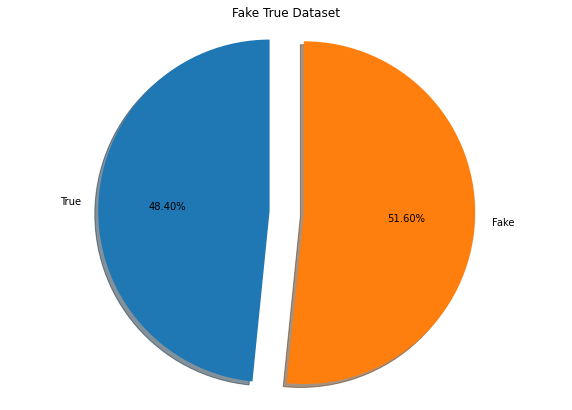

In [ ]:
fig = plt.figure(figsize =(10, 7))
plt.pie(numbers,labels=news, startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%')
plt.title('Fake True Dataset')
plt.axis('equal')
plt.show()


In [ ]:
#from pyspark.sql.functions import concat

In [ ]:
df = spark.sql("select text as News , label from dataframe")
df.show(5)

+--------------------+-----+
|                News|label|
+--------------------+-----+
|No comment is exp...|    1|
| Now, most of the...|    1|
|A dozen political...|    0|
|The RS-28 Sarmat ...|    1|
|All we can say on...|    1|
+--------------------+-----+
only showing top 5 rows



In [ ]:
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
df.dtypes

[('News', 'string'), ('label', 'bigint')]

For Deleting null values


In [ ]:
from pyspark.sql.functions import concat_ws


In [ ]:
df = df.withColumn('News_string', concat_ws(',', 'News'))
df = df.drop('News')

In [ ]:
df.show(5)

+-----+--------------------+
|label|         News_string|
+-----+--------------------+
|    1|No comment is exp...|
|    1| Now, most of the...|
|    0|A dozen political...|
|    1|The RS-28 Sarmat ...|
|    1|All we can say on...|
+-----+--------------------+
only showing top 5 rows



In [ ]:
df.dtypes

[('label', 'bigint'), ('News_string', 'string')]

In [ ]:
from pyspark.sql.functions import split
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.linalg import Vector

Converting string into array of words = Tokenization

In [ ]:
# Tokenize the text column
tokenizer = Tokenizer(inputCol="News_string", outputCol="words")
df = tokenizer.transform(df)


In [ ]:
df = df.drop('News_string')
df.show(5)

+-----+--------------------+
|label|               words|
+-----+--------------------+
|    1|[no, comment, is,...|
|    1|[, now,, most, of...|
|    0|[a, dozen, politi...|
|    1|[the, rs-28, sarm...|
|    1|[all, we, can, sa...|
+-----+--------------------+
only showing top 5 rows



Removing Stop Words

In [ ]:
# Remove stop words
stop_words = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = stop_words.transform(df)
df.show(5)


+-----+--------------------+--------------------+
|label|               words|      filtered_words|
+-----+--------------------+--------------------+
|    1|[no, comment, is,...|[comment, expecte...|
|    1|[, now,, most, of...|[, now,, demonstr...|
|    0|[a, dozen, politi...|[dozen, political...|
|    1|[the, rs-28, sarm...|[rs-28, sarmat, m...|
|    1|[all, we, can, sa...|[say, one, time, ...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df.dtypes

[('label', 'bigint'),
 ('words', 'array<string>'),
 ('filtered_words', 'array<string>')]

Checking for null values as i was getting java null pointer exception

In [ ]:
from pyspark.sql.functions import isnull

df.filter(isnull('filtered_words')).show()

+-----+-----+--------------+
|label|words|filtered_words|
+-----+-----+--------------+
+-----+-----+--------------+



In [ ]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.linalg import Vectors

In [ ]:
# Define the Word2Vec model
word2Vec = Word2Vec(vectorSize=100, inputCol='filtered_words', outputCol='features')

model = word2Vec.fit(df)
df = model.transform(df)



In [ ]:
#from pyspark.ml.feature import Word2VecModel


the above code took around 14 minutes to run

In [ ]:
df.show(5)

+-----+--------------------+--------------------+--------------------+
|label|               words|      filtered_words|            features|
+-----+--------------------+--------------------+--------------------+
|    1|[no, comment, is,...|[comment, expecte...|[-0.0097076267196...|
|    1|[, now,, most, of...|[, now,, demonstr...|[-0.0547487402442...|
|    0|[a, dozen, politi...|[dozen, political...|[-0.0241243856184...|
|    1|[the, rs-28, sarm...|[rs-28, sarmat, m...|[-0.0622058694057...|
|    1|[all, we, can, sa...|[say, one, time, ...|[-0.0234354787581...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df = df.drop('words','filtered_words')
df.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[-0.0097076267196...|
|    1|[-0.0547487402442...|
|    0|[-0.0241243856184...|
|    1|[-0.0622058694057...|
|    1|[-0.0234354787581...|
+-----+--------------------+
only showing top 5 rows



If needed below method can also be used to get feature and response variables.

In [ ]:
X = df.select('features')
y = df.select('label')

In [ ]:
df.dtypes

[('label', 'bigint'), ('features', 'vector')]

In [ ]:
df.count()

100818

Machine Learning Models

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Evaluator AUC Score

In [ ]:
evaluator = BinaryClassificationEvaluator()


In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed=12345)


Logistic Regression

In [ ]:
# Train a logistic regression model using the word vectors as input features
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0,0.1, 0.01]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3
                          )

cvModel_lr = crossval.fit(train)

In [ ]:
predictions_lr = cvModel_lr.transform(test)

In [ ]:
auc_score_lr = evaluator.evaluate(predictions_lr)
auc_score_lr

0.9881349207752821

We can't directly use accuracy while using binary classification so instead we can use this formula


In [ ]:
accuracy_lr = predictions_lr.filter(predictions_lr.label == predictions_lr.prediction).count() / float(predictions_lr.count())
print("Accuracy : ",accuracy_lr)

Accuracy :  0.9515697731999604


RandomForestClassifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier


In [ ]:
# Train a RandomForestClassifier model using the word vectors as input features
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3,5,7]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3
                          )

# Run cross-validation, and choose the best set of parameters.
cvModel_rf = crossval.fit(train)

In [ ]:
predictions_rf = cvModel_rf.transform(test)

In [ ]:
predictions_rf.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[-0.1371433560002...|[16.6684073825216...|[0.83342036912608...|       0.0|
|    0|[-0.1092239692086...|[18.4674647347054...|[0.92337323673527...|       0.0|
|    0|[-0.1083032864480...|[9.10323102066358...|[0.45516155103317...|       1.0|
|    0|[-0.1036650367439...|[16.3077315905476...|[0.81538657952738...|       0.0|
|    0|[-0.1011851922911...|[18.0840999489321...|[0.90420499744660...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
auc_score_rf = evaluator.evaluate(predictions_rf)
auc_score_rf

0.9570326602268212

In [ ]:
accuracy_rf = predictions_rf.filter(predictions_rf.label == predictions_rf.prediction).count() / float(predictions_rf.count())
print("Accuracy : ",accuracy_rf)

Accuracy :  0.8898187580469447


GBTClassifier(Gradient-Boosted Trees)

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
# Train a GBTClassifier model using the word vectors as input features
gbt = GBTClassifier(labelCol="label", featuresCol="features")


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [5,10,20]) \
    .addGrid(gbt.maxDepth, [3,5,7]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3
                          )

# Run cross-validation, and choose the best set of parameters.
cvModel_gbt = crossval.fit(train)

In [ ]:
predictions_gbt = cvModel_gbt.transform(test)

In [ ]:
auc_score_gbt = evaluator.evaluate(predictions_gbt)
auc_score_gbt

0.9760034993521245

In [ ]:
accuracy_gbt = predictions_gbt.filter(predictions_gbt.label == predictions_gbt.prediction).count() / float(predictions_gbt.count())
print("Accuracy : ",accuracy_gbt)

Accuracy :  0.9129939586015648


Linear Support Vector Machine

In [ ]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1)

# Fit the model
lsvcModel = lsvc.fit(train)

In [ ]:
predictions_lsvc = lsvcModel.transform(test)
predictions_lsvc.show(5)

+-----+--------------------+--------------------+----------+
|label|            features|       rawPrediction|prediction|
+-----+--------------------+--------------------+----------+
|    0|[-0.1371433560002...|[2.75718516643774...|       0.0|
|    0|[-0.1092239692086...|[2.08530144669273...|       0.0|
|    0|[-0.1083032864480...|[-0.1462797930916...|       1.0|
|    0|[-0.1036650367439...|[1.80823344588825...|       0.0|
|    0|[-0.1011851922911...|[1.71753529894742...|       0.0|
+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
auc_score_gbt = evaluator.evaluate(predictions_lsvc)
auc_score_gbt

0.9800935685649396

In [ ]:
accuracy_lsvc = predictions_lsvc.filter(predictions_lsvc.label == predictions_lsvc.prediction).count() / float(predictions_lsvc.count())
print("Accuracy : ",accuracy_lsvc)

Accuracy :  0.9302763196989204


Factorization machines classifier


In [ ]:
from pyspark.ml.classification import FMClassifier

In [ ]:
fm = FMClassifier(labelCol="label", featuresCol="features", stepSize=0.001)

fm_model = fm.fit(train)

In [ ]:
predictions_fm = fm_model.transform(test)
predictions_fm.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|    0|[-0.1371433560002...|[0.36990052992999...|[0.59143494273837...|       0.0|
|    0|[-0.1092239692086...|[0.40592795530304...|[0.60011107818356...|       0.0|
|    0|[-0.1083032864480...|[-0.6221855522889...|[0.34928454501701...|       1.0|
|    0|[-0.1036650367439...|[0.04486402654030...|[0.51121412573335...|       0.0|
|    0|[-0.1011851922911...|[0.36701528862993...|[0.59073757054558...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
auc_score_fm = evaluator.evaluate(predictions_fm)
auc_score_fm

0.9081041108348261

In [ ]:
accuracy_fm = predictions_fm.filter(predictions_fm.label == predictions_fm.prediction).count() / float(predictions_fm.count())
print("Accuracy : ",accuracy_fm)

Accuracy :  0.7782014459740517


For Scrapped data

In [ ]:
scrapped_dataframe = spark.read.csv('/content/drive/MyDrive/Project (1)/TwitterData.csv',inferSchema=True,header=True)

In [ ]:
scrapped_dataframe.createOrReplaceTempView("dataframe")

In [ ]:
spark.sql("select * from dataframe").show(5)

+--------------------+--------------------+--------------------+
|                 _c0|                Date|               Tweet|
+--------------------+--------------------+--------------------+
|                   0|2023-02-23 13:02:...|Rubina &amp; Fais...|
|#RubinaDilaik #Ru...|                null|                null|
|                   1|2023-02-23 13:02:...|Is Chicago ready ...|
|                   2|2023-02-23 13:02:...|@__SeriousGemini ...|
|                   3|2023-02-23 13:02:...|Really sad news a...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
output = spark.sql("select Tweet as features from dataframe")

In [ ]:
output = output.withColumn('News_string', concat_ws(',', 'features'))
output = output.drop('features')

In [ ]:
tokenizer = Tokenizer(inputCol="News_string", outputCol="words")
output = tokenizer.transform(output)

In [ ]:
stop_words = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df = stop_words.transform(output)


In [ ]:
from pyspark.sql.functions import isnull

df.filter(isnull('filtered_words')).show()

+-----------+-----+--------------+
|News_string|words|filtered_words|
+-----------+-----+--------------+
+-----------+-----+--------------+



In [ ]:
# word2Vec = Word2Vec(vectorSize=100, inputCol='filtered_words', outputCol='features')

# model = word2Vec.fit(df)
output = model.transform(df)

In [ ]:
predictions_gbt = cvModel_lr.transform(output)
predictions_gbt=predictions_gbt.drop('News_string')


In [ ]:
predictions_gbt.createOrReplaceTempView('predictions')

In [ ]:
spark.sql("select count(prediction) as count , prediction from predictions group by prediction").show()

+-----+----------+
|count|prediction|
+-----+----------+
| 8986|       0.0|
|62981|       1.0|
+-----+----------+



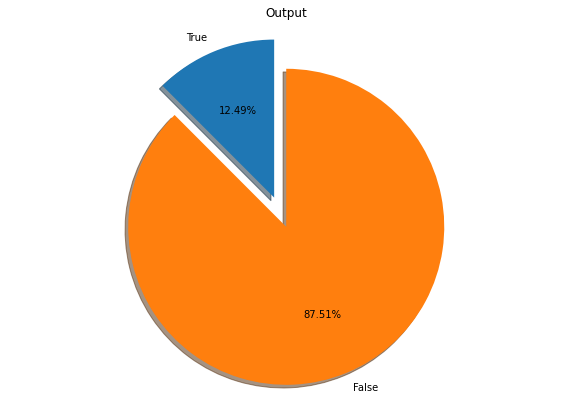

In [ ]:
numbers= spark.sql("select count(prediction) as count, prediction from predictions group by prediction").to_pandas_on_spark()['count'].to_numpy()
labels = ['True','False']
fig = plt.figure(figsize =(10, 7))
plt.pie(numbers,labels=labels,startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%')
plt.title('Output')
plt.axis('equal')
plt.show()

In [ ]:
scrapped_dataframe = spark.read.csv('/content/drive/MyDrive/Project (1)/TwitterData.csv',inferSchema=True,header=True)

Function to predict total number of fake and true news in a dataset

In [ ]:
def predict_scrapped_data(scrapped_dataframe):    
  scrapped_dataframe.createOrReplaceTempView("dataframe")
  output = spark.sql("select Tweet as features from dataframe")
  output = output.withColumn('News_string', concat_ws(',', 'features'))
  output = output.drop('features')
  tokenizer = Tokenizer(inputCol="News_string", outputCol="words")
  output = tokenizer.transform(output)
  stop_words = StopWordsRemover(inputCol="words", outputCol="filtered_words")
  output = stop_words.transform(output)
  output = model.transform(output)
  predictions = cvModel_lr.transform(output)
  value = predictions.to_pandas_on_spark()['prediction'].to_numpy()
  news = ['True','Fake']
  fig = plt.figure(figsize =(10, 7))
  plt.pie(numbers,labels=news, startangle=90, shadow=True,explode=(0.1, 0.1), autopct='%1.2f%%')
  plt.title('Scrapped Data Distribution')
  plt.axis('equal')
  plt.show()

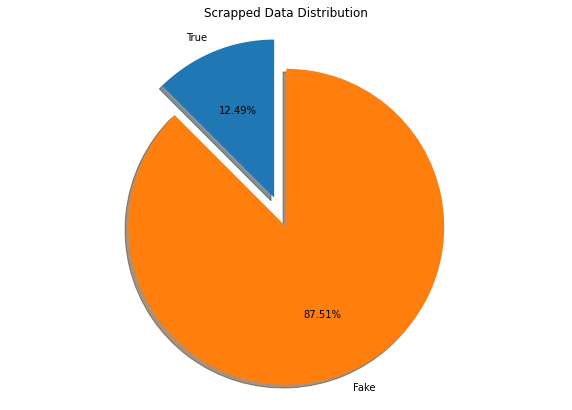

In [ ]:
predict_scrapped_data(scrapped_dataframe)

Function to predict one news

In [ ]:
def predict_news():  
  input_news = input("Enter the News to check : ")
  new_dataframe  = spark.createDataFrame([(input_news,)], ["features"])
  new_dataframe = new_dataframe.withColumn('News_string', concat_ws(',', 'features'))
  new_dataframe = new_dataframe.drop('features')
  tokenizer = Tokenizer(inputCol="News_string", outputCol="words")
  new_dataframe = tokenizer.transform(new_dataframe)
  stop_words = StopWordsRemover(inputCol="words", outputCol="filtered_words")
  output = stop_words.transform(new_dataframe)
  output = model.transform(output)
  predictions = cvModel_lr.transform(output)
  predictions=predictions.drop('rawPrediction','probability','News_string')
  value = predictions.select("prediction").collect()[0][0]
  if value == 0:
    print('True News')
  elif value == 1:
    print('Fake News')

I have commented it as it will consistently ask for Input

In [ ]:
#predict_news()

In [ ]:
#cvModel_lr.save('/content/drive/MyDrive/Kaggle datasets/model')

In [ ]:
# from pyspark.ml.classification import GBTClassificationModel
# from pyspark.ml.tuning import CrossValidator,CrossValidatorModel

In [ ]:
# loaded_model = CrossValidatorModel.load("/content/drive/MyDrive/Kaggle datasets/model")

In [ ]:
# loaded_model.transform(test).createOrReplaceTempView("data")

In [ ]:
# spark.sql("select prediction,count(prediction) as count from data group by prediction").show()

In [ ]:
#cvModel_lr.save('/content/drive/MyDrive/Project/lr_model')

In [ ]:
#cvModel_rf.save('/content/drive/MyDrive/Project/rf_model')

In [ ]:
#cvModel_gbt.save('/content/drive/MyDrive/Project/gbt_model')

In [ ]:
#lsvcModel.save('/content/drive/MyDrive/Project/lsvc_model')

In [ ]:
#model.save('/content/drive/MyDrive/Project/word2vec_model')

In [ ]:
#fm_model.save('/content/drive/MyDrive/Project/fm_model')